In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from dfreproject import calculate_rays
from sunpy.data.sample import AIA_193_JUN2012, STEREO_A_195_JUN2012
import matplotlib.pyplot as plt
import torch
from astropy.io.fits import PrimaryHDU
from dfreproject import TensorHDU
from einops import rearrange, reduce, repeat

torch.Size([1, 1025, 1025, 3])
rays requires_grad: False


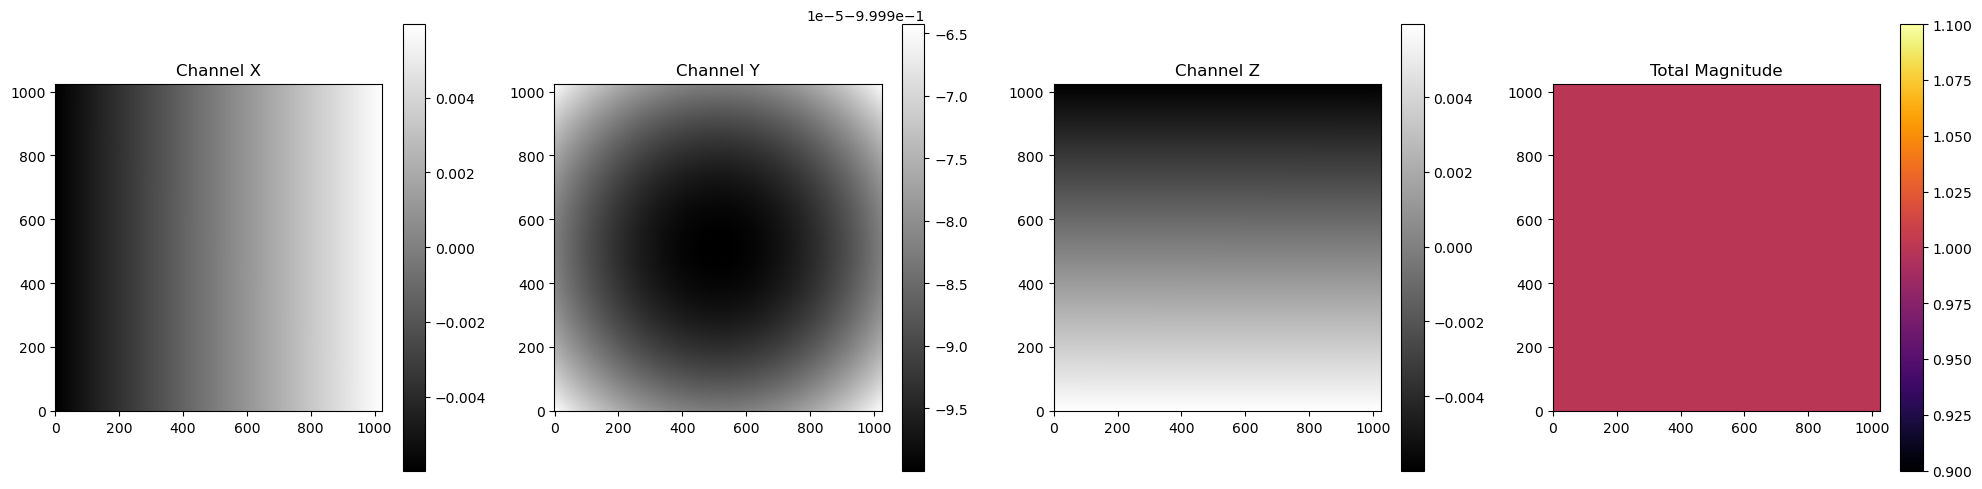

[[ 0.00595332  0.00595331  0.0059533  ...  0.00594158  0.00594157
   0.00594155]
 [ 0.00594167  0.00594166  0.00594165 ...  0.00592993  0.00592992
   0.0059299 ]
 [ 0.00593002  0.00593001  0.00593    ...  0.00591828  0.00591827
   0.00591826]
 ...
 [-0.00595278 -0.00595279 -0.00595281 ... -0.00596453 -0.00596454
  -0.00596455]
 [-0.00596443 -0.00596444 -0.00596446 ... -0.00597618 -0.00597619
  -0.0059762 ]
 [-0.00597608 -0.00597609 -0.00597611 ... -0.00598783 -0.00598784
  -0.00598785]]
obs: tensor([0.0000e+00, 1.5169e+11, 9.2886e-06], device='cuda:0',
       dtype=torch.float64)
Magnitude of obs: 151693704651.16


In [2]:
# Load source and target images
source_hdu = fits.open(AIA_193_JUN2012)[1]
source_hdu = PrimaryHDU(source_hdu.data, header=source_hdu.header)

shape = source_hdu.data.shape


source_hdu = TensorHDU(torch.tensor(source_hdu.data, requires_grad=True), source_hdu.header)
source_wcs = WCS(source_hdu.header)

# Use the downscale_and_update_fits function defined above
# downscale_size = 1024
# source_hdu, target_hdu, target_wcs = downscale_and_update_fits(source_hdu, target_hdu, target_wcs, downscale_size=downscale_size)
# print(type(source_hdu))

# Extract HGLT_OBS (heliographic latitude of observer) from WCS if present
# print("Lat", source_wcs.wcs.aux.hglt_obs)
# print("Lon", source_wcs.wcs.aux.hgln_obs)
# print("HGLT_OBS from WCS:", hglt_obs)

source_wcs.wcs.aux.hglt_obs = 90.0  # Set to zero for this example
source_wcs.wcs.aux.hgln_obs = 0.0  # Set to


obs, rays = calculate_rays(
    source_wcs = source_wcs,
    shape_out=shape,
    corners=True,
    requires_grad=False
)
_, rays_centered = calculate_rays(
    source_wcs = source_wcs,
    shape_out=shape,
    corners=False,
    requires_grad=False
)

print(rays.shape)  # Should match target_hdu.data.shape
print("rays requires_grad:", rays.requires_grad)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

channels = ['X', 'Y', 'Z']
for i in range(3):
    ax = axes[i]
    im = ax.imshow(rays[0, :, :, i].cpu().detach().numpy(), origin='lower', cmap='gray')
    ax.set_title(f'Channel {channels[i]}')
    plt.colorbar(im, ax=ax)

# Total magnitude
magnitude = torch.norm(rays[0], dim=-1).cpu().detach().numpy()
im = axes[3].imshow(magnitude, origin='lower', cmap='inferno')
axes[3].set_title('Total Magnitude')
plt.colorbar(im, ax=axes[3])

plt.tight_layout()
plt.show()

z = rays[0, :, :, 2].cpu().detach().numpy()
print(z)

print("obs:", obs)
print("Magnitude of obs:", torch.norm(obs).item())


rsun = int(6.9634e8)

def sun_sphere_scalar(coords, radius=rsun, radius2= rsun/2, radius3 = rsun/3, value=1.0):
    """
    Returns an array where points inside the sphere of given radius are set to `value`, else 0.
    coords: tensor or array of shape (..., 3) representing (x, y, z) coordinates (units: meters)
    radius: radius of the sphere (default: Sun's radius in meters)
    value: value to assign inside the sphere
    """
    if isinstance(coords, torch.Tensor):
        dist2 = coords[..., 0]**2 + coords[..., 1]**2 + coords[..., 2]**2
        mask = dist2 <= radius**2
        # Define new sphere center: shift x and y positively, keep z the same
        # Example: center at (radius, radius, 0)
        center_2 = torch.tensor([radius, radius, 0.0], dtype=coords.dtype, device=coords.device)
        dist2_new = (coords[..., 0] - center_2[0])**2 + (coords[..., 1] - center_2[1])**2 + (coords[..., 2] - center_2[2])**2
        mask_new = dist2_new <= radius2**2
        # Intersecting region: both masks True
        mask_combined = mask | mask_new

        center_3 = torch.tensor([-radius, -radius, radius/2], dtype=coords.dtype, device=coords.device)
        dist2_new = (coords[..., 0] - center_3[0])**2 + (coords[..., 1] - center_3[1])**2 + (coords[..., 2] - center_3[2])**2
        mask_new = dist2_new <= radius3**2

        # Torus parameters
        torus_center = center_3
        torus_major_radius = radius3 * 1.5  # distance from center to tube center
        torus_minor_radius = radius3 / 4    # tube radius

        # Compute torus mask: (sqrt(x^2 + y^2) - major_radius)^2 + z^2 <= minor_radius^2
        x = coords[..., 0] - torus_center[0]
        y = coords[..., 1] - torus_center[1]
        z = coords[..., 2] - torus_center[2]
        torus_r = torch.sqrt(x**2 + z**2)
        torus_mask = ((torus_r - torus_major_radius)**2 + y**2) <= torus_minor_radius**2

        mask_combined = mask_combined | mask_new | torus_mask


    
        result = torch.where(mask_combined, torch.tensor(value, dtype=coords.dtype, device=coords.device), torch.tensor(0.0, dtype=coords.dtype, device=coords.device))
        return result


    

rays_no_batch requires_grad: False
rays_no_batch shape: torch.Size([1025, 1025, 3, 1])
rays_centered shape: torch.Size([1024, 1024, 3, 1])
steps shape: torch.Size([1, 1, 1, 279])


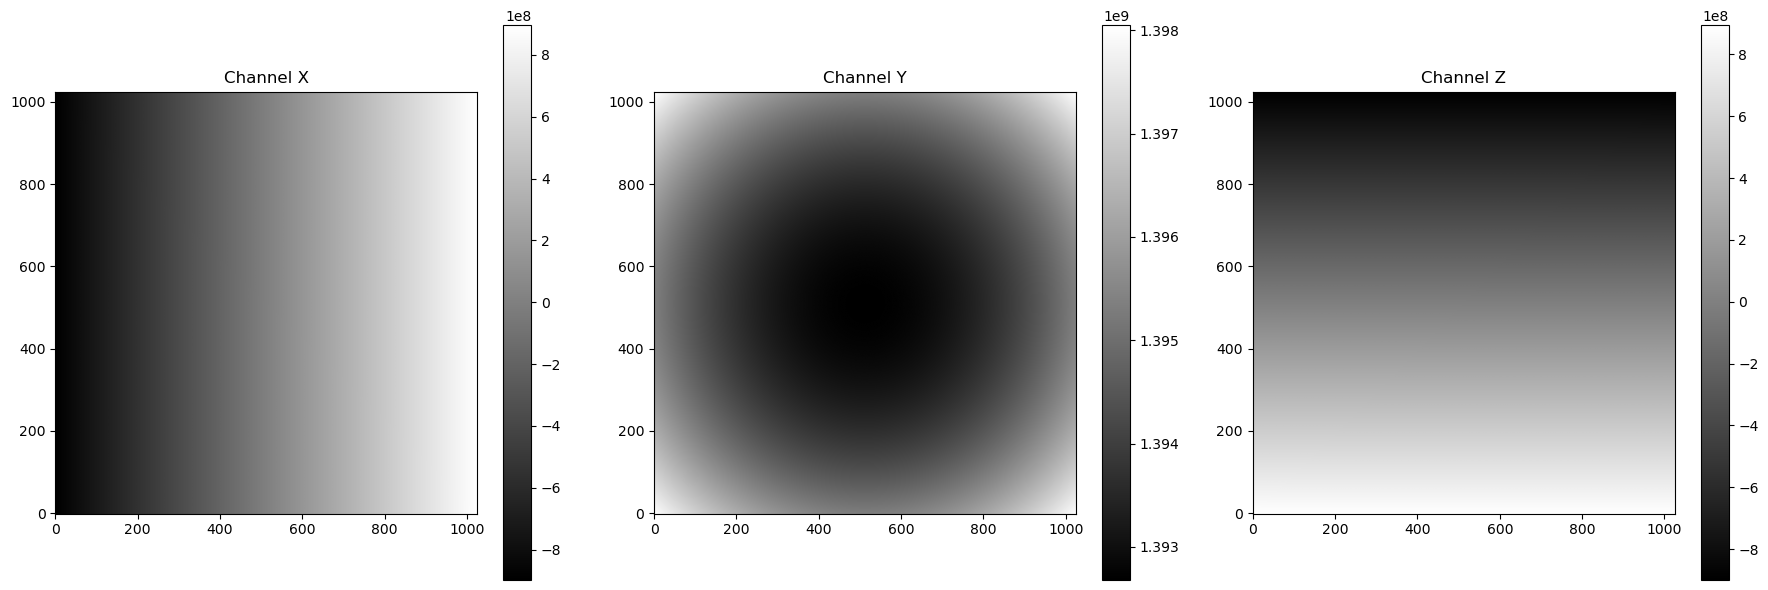

Shape of rays_with_obs: torch.Size([1025, 1025, 3, 279])
Shape of diff: torch.Size([3, 279])
Shape of norm: torch.Size([279])
average_cropped shape: torch.Size([1024, 1024, 3, 279])


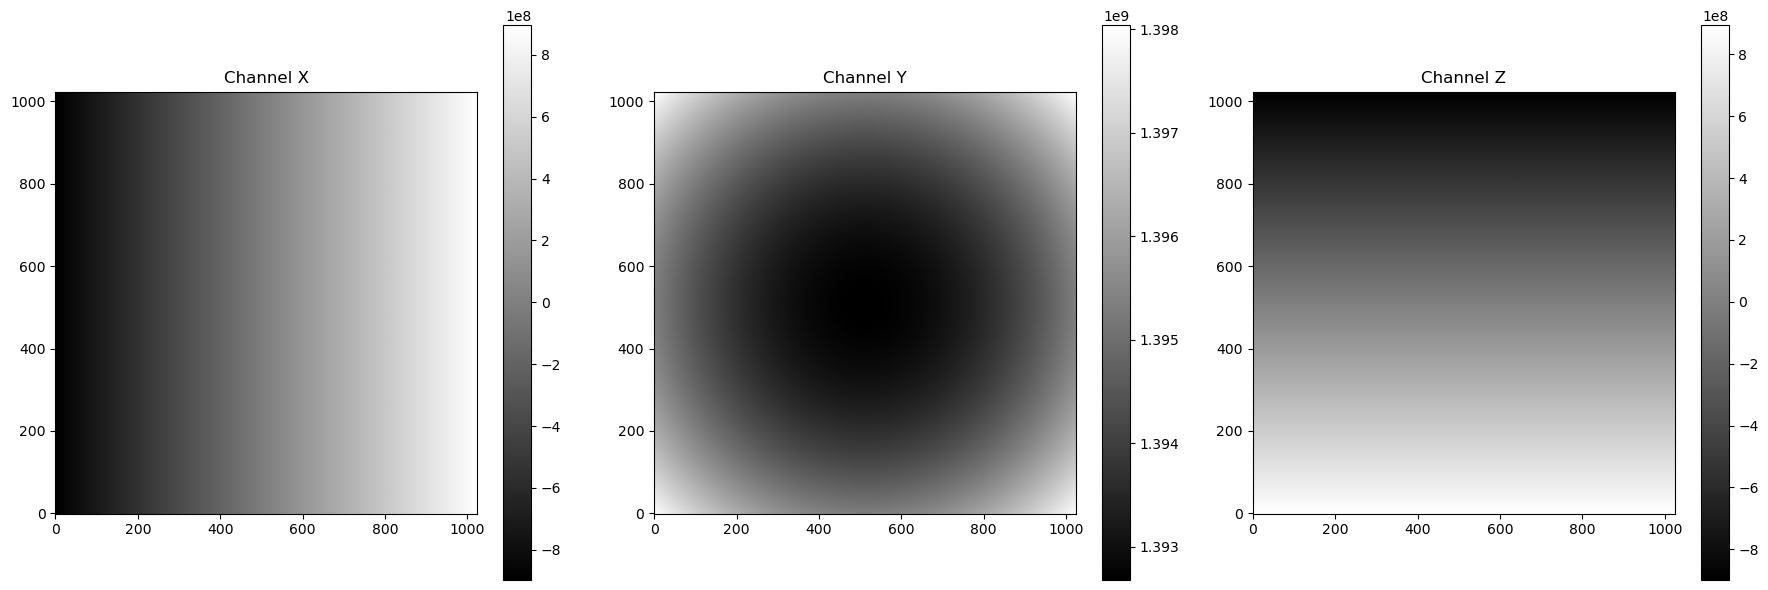

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06078612804412842..5.1000518798828125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06078612804412842..5.1000518798828125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06078612804412842..5.1000518798828125].


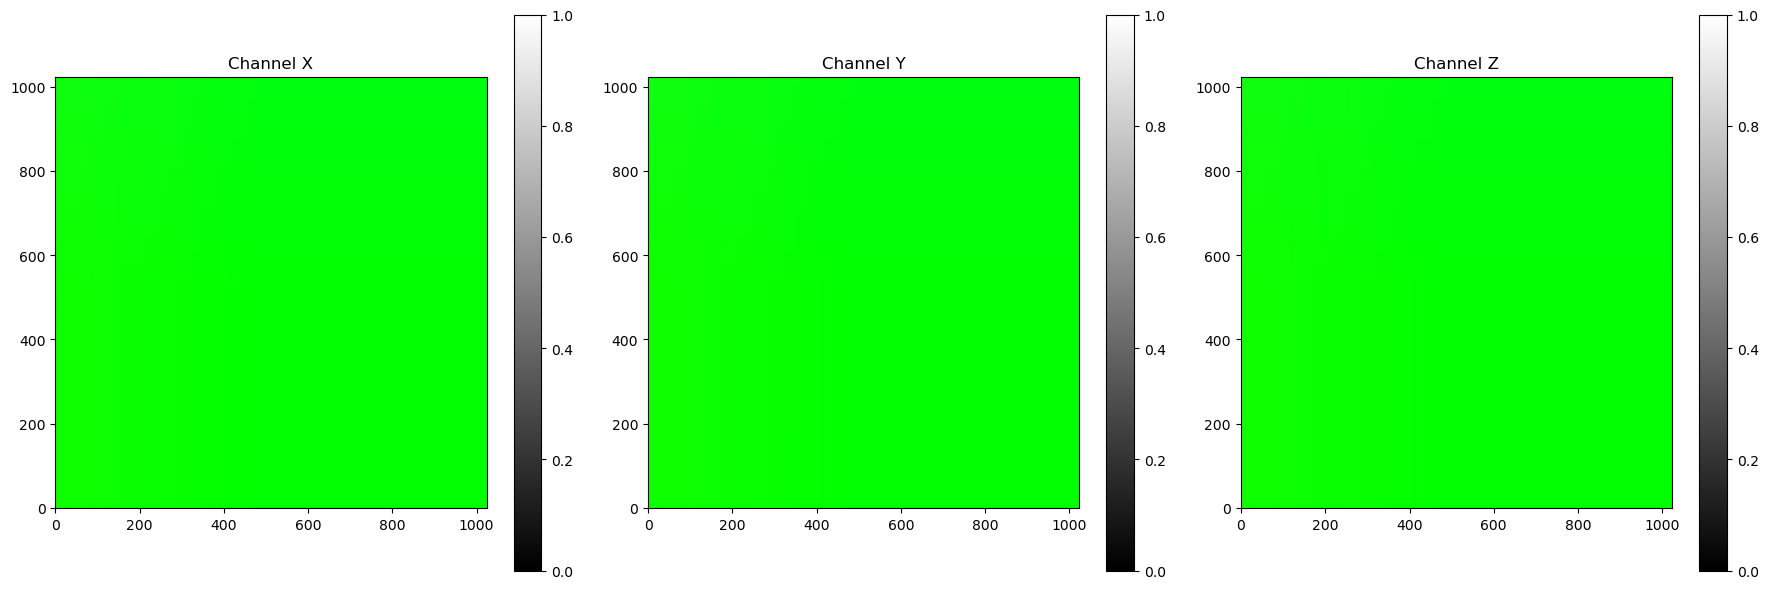

In [ ]:
import time


dsun = torch.norm(obs)  # Distance from observer to Sun in meters

dsun = dsun.to(dtype=torch.int64, device=obs.device)

# Add the obs vector to each coordinate in rays[0]
# rays has shape (1, H, W, 3), obs has shape (3,)
# Remove batch dimension for easier broadcasting and visualization
rays_no_batch = rearrange(rays, "1 h w c -> h w c 1")  # shape (H, W, 3)
rays_centered = rearrange(rays_centered, "1 h w c -> h w c 1")  # shape (H, W, 3)

print("rays_no_batch requires_grad:", rays_no_batch.requires_grad)
dx = 10000000




steps = torch.arange(dsun - 2*rsun, dsun + 2*rsun, dx, device=dsun.device, dtype=rays.dtype)
steps = rearrange(steps, "s -> 1 1 1 s")

print("rays_no_batch shape:", rays_no_batch.shape)
print("rays_centered shape:", rays_centered.shape)
print("steps shape:", steps.shape)


rays_with_steps = rays_no_batch*steps

rays_centered_with_steps = rays_centered * steps




del rays_no_batch, steps
obs = rearrange(obs, "c -> 1 1 c 1")

rays_with_obs = rays_with_steps + obs

rays_centered_with_obs =  rays_centered_with_steps + obs

section = rays_centered_with_obs[:, :, :, 0]  # Extract the first section for visualization
del rays_centered_with_obs, rays_centered_with_steps

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
channels = ['X', 'Y', 'Z']
for i in range(3):
    ax = axes[i]
    im = ax.imshow(rays_with_obs[:, :, i, 0].cpu().detach().numpy(), origin='lower', cmap='gray')
    ax.set_title(f'Channel {channels[i]}')
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("Shape of rays_with_obs:", rays_with_obs.shape)
del rays_with_steps
torch.cuda.empty_cache()


H, W = rays_with_obs.shape[0], rays_with_obs.shape[1]
h1, w1 = H // 2, W // 2
w2 = H // 2 + 1

ref_pix1 = rays_with_obs[h1, w1, :, :]  # Reference pixel at (h1, w1)
ref_pix2 = rays_with_obs[h1, w2, :, :]  # Reference pixel at (h1, w2)

diff = ref_pix2 - ref_pix1
print("Shape of diff:", diff.shape)
norm = torch.norm(diff, dim=0)
print("Shape of norm:", norm.shape)
area = norm ** 2
area = rearrange(area , "c -> 1 1 c 1")  # Reshape to match rays_with_obs shape

del ref_pix1, ref_pix2, diff, norm


def pad_top(tensor, pad_size):
    """Pad zeros to the top of a 4D tensor (h, w, c, s)."""
    pad_shape = (pad_size, tensor.shape[1], tensor.shape[2], tensor.shape[3])
    pad_tensor = torch.zeros(pad_shape, dtype=tensor.dtype, device=tensor.device)
    return torch.cat([pad_tensor, tensor], dim=0)

def pad_bottom(tensor, pad_size):
    """Pad zeros to the bottom of a 4D tensor (h, w, c, s)."""
    pad_shape = (pad_size, tensor.shape[1], tensor.shape[2], tensor.shape[3])
    pad_tensor = torch.zeros(pad_shape, dtype=tensor.dtype, device=tensor.device)
    return torch.cat([tensor, pad_tensor], dim=0)

def pad_left(tensor, pad_size):
    """Pad zeros to the left of a 4D tensor (h, w, c, s)."""
    pad_shape = (tensor.shape[0], pad_size, tensor.shape[2], tensor.shape[3])
    pad_tensor = torch.zeros(pad_shape, dtype=tensor.dtype, device=tensor.device)
    return torch.cat([pad_tensor, tensor], dim=1)

def pad_right(tensor, pad_size):
    """Pad zeros to the right of a 4D tensor (h, w, c, s)."""
    pad_shape = (tensor.shape[0], pad_size, tensor.shape[2], tensor.shape[3])
    pad_tensor = torch.zeros(pad_shape, dtype=tensor.dtype, device=tensor.device)
    return torch.cat([tensor, pad_tensor], dim=1)


# upper_right = pad_top(pad_right(rays_with_obs, 1), 1)
# lower_left = pad_bottom(pad_left(rays_with_obs, 1), 1)
# upper_left = pad_top(pad_left(rays_with_obs, 1), 1)
# lower_right = pad_bottom(pad_right(rays_with_obs, 1), 1)
average = (pad_top(pad_right(rays_with_obs, 1), 1) + pad_bottom(pad_left(rays_with_obs, 1), 1) + pad_top(pad_left(rays_with_obs, 1), 1) + pad_bottom(pad_right(rays_with_obs, 1), 1)) / 4


# Remove the top, bottom, left, and right rows/columns from average
average_cropped = average[1:-1, 1:-1, :, :]
del average

print("average_cropped shape:", average_cropped.shape)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
channels = ['X', 'Y', 'Z']
for i in range(3):
    ax = axes[i]
    im = ax.imshow(average_cropped[:, :, i, 0].cpu().detach().numpy(), origin='lower', cmap='gray')
    ax.set_title(f'Channel {channels[i]}')
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

diff = average_cropped[:,:,:,0] - section

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
channels = ['X', 'Y', 'Z']
for i in range(3):
    ax = axes[i]
    im = ax.imshow(diff[:, : i].cpu().detach().numpy(), origin='lower', cmap='gray')
    ax.set_title(f'Channel {channels[i]}')
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()





In [ ]:

rays_with_obs = rearrange(rays_with_obs, "h w c s -> h w s c")

print("rays_with_obs shape:", rays_with_obs.shape)
print("rays_with_obs dtype:", rays_with_obs.dtype)
print(torch.cuda.memory_allocated() / 1e6, "MB")


start = time.time()
output_tensor = sun_sphere_scalar(rays_with_obs, radius=6.9634e8, value=1.0)
end = time.time()
print(f"sun_sphere_scalar took {end - start:.2f} seconds")

start = time.time()
output_tensor = reduce(output_tensor, 'h w s -> h w', 'sum')
end = time.time()
print(f"reduce (sum) took {end - start:.2f} seconds")




print("output_tensor requires_grad:", output_tensor.requires_grad)

plt.figure(figsize=(8, 6))
plt.imshow(output_tensor.cpu().detach().numpy(), origin='lower', cmap='viridis')
plt.title('Output Tensor (Sun Sphere Mask Accumulation)')
plt.colorbar()
plt.show()


torch.cuda.empty_cache()
del rays_with_obs, output_tensor


print('current memory allocated: {}'.format(torch.cuda.memory_allocated() / 1024 ** 2))
print('max memory allocated: {}'.format(torch.cuda.max_memory_allocated() / 1024 ** 2))
print('cached memory: {}'.format(torch.cuda.memory_reserved() / 1024 ** 2))
